# Control Variate Technique for Binomial Tree Prices

### Motivation
This illustrates the use of the Control Variate technique for reducing the variance of an estimate for an option price calculated on a Binomial tree. See  https://en.wikipedia.org/wiki/Control_variates or Simulation by S.M. Ross. The application to pricing American Put options using the corresponding European option is discussed by 
Hull \& White in 'The Use of the Control Variate Technique in Option Pricing', J. of Finance, 42 (June 1987), 281-300; THE CONVERGENCE OF BINOMIAL TREES FOR PRICING
THE AMERICAN PUT M.Joshi 2008; and
[On the use and improvement of Hull and White’s control variate technique](https://scholars.lib.ntu.edu.tw/bitstream/123456789/165629/1/22.pdf)



Here we price an American option by using the corresponding European option which has an analytic expression for it's price given by the Black-Scholes formula. We first estimate the optimal coefficient, $c^*$ in the expression
$$Z\equiv A + c(E - \mu_E)$$ so as to minimize it's variance: 
$$Var[Z] = Var[A] + c^2Var[E] +2cCov[A,E]$$
$$c^* = -Cov(A,E) / Var(E).$$ We then have $$E[Z] = E[A]$$ $$Var[Z] = Var[A] -(Cov[A,E])^2 / Var[E]$$ 
or:
$${Var[Z]\over Var[A]} = (1 - Corr^2[A,E])$$
By choosing A, E as the price of the American, European option calculated on the binomial tree, and setting $\mu_E$ as the Black-Scholes price of the European option, $Z$ calculated from the binomial tree will estimate the price of the American option with reduced variance. 

Strictly speaking, this technique applies to sampling from a fixed distribution of random numbers. We estimate $c^*$ from sample estimates of $Cov[A, E]$ and $Var[E]$ where $A, E$ are sample realizations drawn from that distribution. As applied in the above mentioned references, and here, $A, E$ are American and European option prices obtained from Binomial trees. A Binomial tree of a given number of timesteps, `N_steps`, produces a  single, completely deterministic price. One can easily imagine using the technique on option prices produced by a (fixed) Monte Carlo engine where each realized price is a random number drawn from the distribution produced by that MC engine (number of timesteps, $r, \sigma, T,...$ all fixed). Estimating c* from the first several realizations of (A, E), then allows to construct $Z$ with the above properties on subsequent simulations from that same MC engine.

What is the distribution we are drawing $A, E$ from when the are option prices produced by Binomial trees? Following the previous authors, we let the number of time steps, `N_steps`[<sup id="fn1-back">1</sup>](#fn1), used in the construction of the binomial tree play the role of randomness, i.e., we estimate $c^*$, $Cov[A,E], Var[E]$ from a 'sample' of trees having some range of `N_steps`. We imagine that by observing how $A, E$ covary, we can form the above $Z$, which will then have the same mean and smaller variance over this selected range of `N_steps`. Let's see how this works.







[<sup id="fn1">1</sup>](#fn1-back) only `N_steps` varies, all other parameters($S_o, r, T, K, \sigma, ...$) of the tree and option are fixed.




In [1]:
#include "option_pricing.hpp"
#include "option_pricing.cc"

In [2]:
// Create Amer and Euro option prices on binomial trees having N_steps on [20,100]:

#include <fstream>
#include <iomanip>

using namespace OptionPricing;
using std::cout;
using std::endl;
using std::valarray;


// Construct the Amer and Euro Put options for a particular parameter set:
double S_o = 40.0, r = 0.0488, q = 0.0;
double K = 40.0, T = 7 / 12., sigma = 0.2;
Asset underlying{ S_o, q, sigma };
Terms terms_amer_put{ Terms::Style::Amer, Terms::Type::Put, T, K };
Terms terms_euro_put{ Terms::Style::Euro, Terms::Type::Put, T, K };
Option amer_put(terms_amer_put, underlying);
Option euro_put(terms_euro_put, underlying);

// Write to file their prices on the training set of binomial trees having N_steps on [20, 100]:
bool get_greeks = false;
constexpr int start_N = 20, end_N = 100;
constexpr int N_points{ end_N - start_N + 1 }; // Number of training points.
std::fstream outfile("prcs_20-100.csv", std::ios_base::out);
for (int N_steps = start_N; N_steps < end_N + 1; ++N_steps) {
    double a = amer_put.btree_prc(N_steps, r, get_greeks);
    double e = euro_put.btree_prc(N_steps, r, get_greeks);
    outfile << N_steps << "," << std::setprecision(12) << a << ',' << e << "\n";
}
outfile.close();


BS_prc: 1.8812198652840362


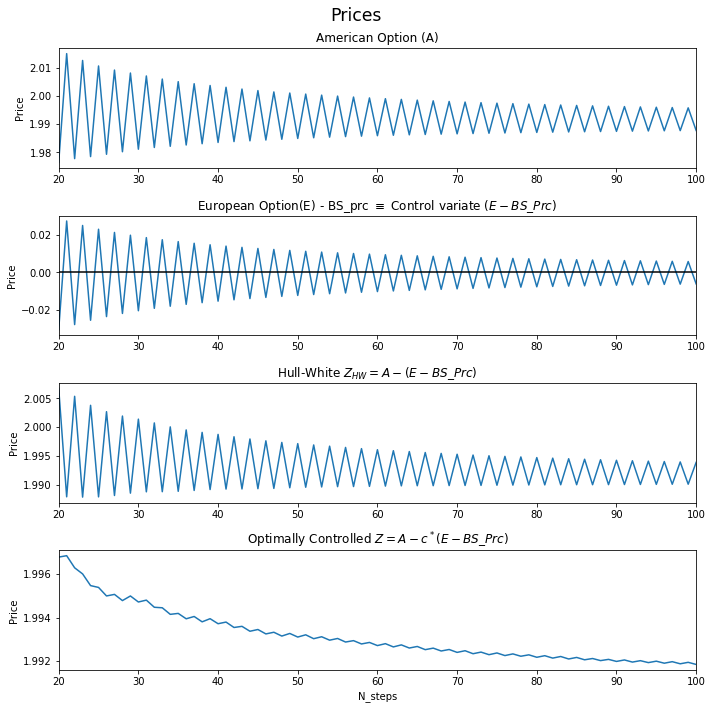

Optimal Control Variate coefficient c*: 0.6697
Variance | stddev of A:    8.176e-05 | 0.0090
Variance | stddev of Z_HW: 2.100e-05 | 0.0046
Variance | stddev of Z:    1.468e-06 | 0.0012
Mean A | Mean E - BS_prc:   1.992744691 | -0.000623816


In [22]:
# Read in the American, European option prices, find Var[A], Cov[A,E] and c*.
# Form Z = A - c* (E - BS_Prc):
import numpy as np
import math
import matplotlib.pyplot as plt

N_steps, a, e = np.loadtxt("prcs_20-100.csv", delimiter=',', unpack=True)

# Calculate the Black-Scholes price for Euro option:
S_o = 40.0
r = 0.0488
q = 0.0
K = 40.0
T = 7 / 12
sigma = 0.2

d_1 = (math.log(S_o / K) + (r - q + sigma**2 / 2) * T) / (sigma * math.sqrt(T))
d_2 = d_1 - sigma * math.sqrt(T)
BS_prc = np.exp(-r * T) * K * math.erfc(d_2 / math.sqrt(2)) / 2 - S_o * math.erfc(d_1 / math.sqrt(2)) / 2;
print(f"BS_prc: {BS_prc}")

# Plot A and E - BS_prc:
fig, ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(N_steps, a)
ax[0].set_title("American Option (A)")
ax[0].set_xlim(N_steps[0], N_steps[-1])
ax[0].set_ylabel('Price')

ax[1].plot(N_steps, e - BS_prc)
ax[1].set_title("European Option(E) - BS_prc $\equiv$ Control variate ($E-BS\_Prc$)")
ax[1].axhline(y=0, color="black")
ax[1].set_xlim(N_steps[0], N_steps[-1])
ax[1].set_ylabel('Price')

# Create z_HW, and Z from c:
z_HW = a - (e - BS_prc)
var_Z_HW = z_HW.var(ddof=1)
cov_A_E = np.cov(a, e)
c = cov_A_E[0,1] / cov_A_E[1,1]
var_A = cov_A_E[0,0]
z = a - c * (e - BS_prc)
var_Z = z.var(ddof=1)

# Plot them:
ax[2].plot(N_steps, z_HW)
ax[2].set_title("Hull-White $Z_{HW}=A - (E-BS\_Prc)$")
ax[2].set_xlim(N_steps[0], N_steps[-1])
ax[2].set_ylabel('Price')

ax[3].plot(N_steps, z)
ax[3].set_title("Optimally Controlled $Z=A - c^*(E-BS\_Prc)$")
ax[3].set_xlim(N_steps[0], N_steps[-1])
ax[3].set_xlabel('N_steps')
ax[3].set_ylabel('Price')
fig.suptitle("Prices", fontsize="xx-large")

fig.tight_layout()
plt.show()

# Look at the Vars and means on this interval of N_steps: 
print(f"Optimal Control Variate coefficient c*: {c:.4}")
print(f"Variance | stddev of A:    {var_A:6.3e} | {math.sqrt(var_A):6.4f}")
print(f"Variance | stddev of Z_HW: {var_Z_HW:6.3e} | {math.sqrt(var_Z_HW):6.4f}")
print(f"Variance | stddev of Z:    {var_Z:6.3e} | {math.sqrt(var_Z):6.4f}")
print(f"Mean A | Mean E - BS_prc:   {a.mean():10.9f} | {(e-BS_prc).mean():10.9f}")


A and E each exhibit an alternating series property wrt N_steps. The size of these alternating up/down steps is decreasing. The variance of $Z_{HW}$ is larger than that of $Z$, and if `N_steps` was not an ordered set we could safely say that $Z$ estimates A better than $Z_{HW}$ does, but in reality, we can't because, while removing most of the pairwise alternating character of the series, it leaves(exposes) the seriel dependence of A on `N_steps`. Let's continue to larger trees.

In [ ]:
   // Write to another file their prices on some other set of binomial trees:
    int test_start_N = 4000;
    int test_end_N = 4000 + N_points - 1;
    outfile.open("prcs_4000-4080.csv", std::ios_base::out);
    for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
        double a = amer_put.btree_prc(N_steps, r, get_greeks);
        double e = euro_put.btree_prc(N_steps, r, get_greeks);
        outfile << N_steps << "," << std::setprecision(10) << a << ',' << e << "\n";
    }
    outfile.close();


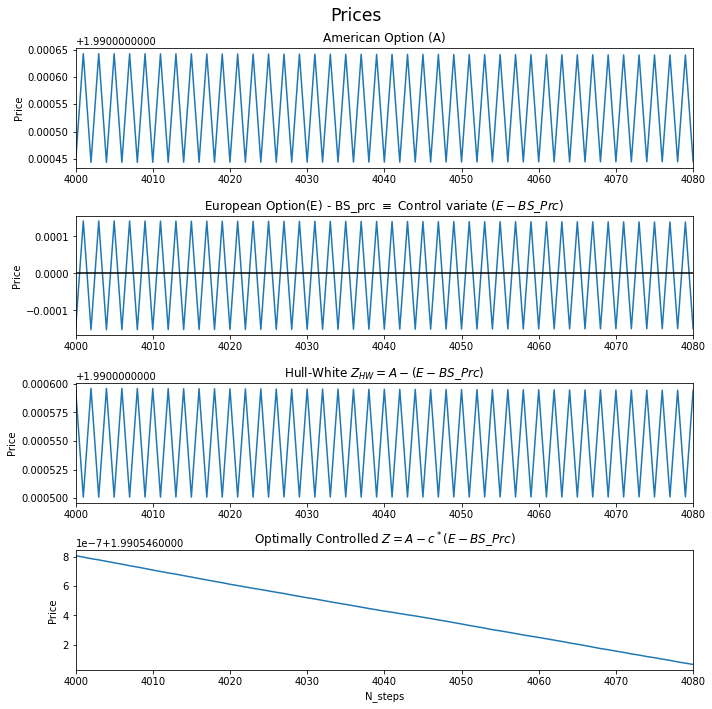

Optimal Control Variate coefficient c*: 0.6767
Variance | stddev of A:    9.845e-09 | 9.922e-05
Variance | stddev of Z_HW: 2.247e-09 | 4.740e-05
Variance | stddev of Z:    4.677e-14 | 2.163e-07
Mean A | Mean E - BS_prc:   1.990541601 | -0.000007139


In [23]:
# Repeat for N_steps on [4000, 4080]:
N_steps, a, e = np.loadtxt("prcs_4000-4080.csv", delimiter=',', unpack=True)

# Plot A and E - BS_prc:
fig, ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(N_steps, a)
ax[0].set_title("American Option (A)")
ax[0].set_xlim(N_steps[0], N_steps[-1])
ax[0].set_ylabel('Price')

ax[1].plot(N_steps, e - BS_prc)
ax[1].set_title("European Option(E) - BS_prc $\equiv$ Control variate ($E-BS\_Prc$)")
ax[1].axhline(y=0, color="black")
ax[1].set_xlim(N_steps[0], N_steps[-1])
ax[1].set_ylabel('Price')

# Create z_HW, and Z from c:
z_HW = a - (e - BS_prc)
var_Z_HW = z_HW.var(ddof=1)
cov_A_E = np.cov(a, e)
c = cov_A_E[0,1] / cov_A_E[1,1]
var_A = cov_A_E[0,0]
z = a - c * (e - BS_prc)
var_Z = z.var(ddof=1)

ax[2].plot(N_steps, z_HW)
ax[2].set_title("Hull-White $Z_{HW}=A - (E-BS\_Prc)$")
ax[2].set_xlim(N_steps[0], N_steps[-1])
ax[2].set_ylabel('Price')

ax[3].plot(N_steps, z)
ax[3].set_title("Optimally Controlled $Z=A - c^*(E-BS\_Prc)$")
ax[3].set_xlim(N_steps[0], N_steps[-1])
ax[3].set_xlabel('N_steps')
ax[3].set_ylabel('Price')
fig.suptitle("Prices", fontsize="xx-large")

fig.tight_layout()
plt.show()

print(f"Optimal Control Variate coefficient c*: {c:.4}")
print(f"Variance | stddev of A:    {var_A:6.3e} | {math.sqrt(var_A):6.3e}")
print(f"Variance | stddev of Z_HW: {var_Z_HW:6.3e} | {math.sqrt(var_Z_HW):6.3e}")
print(f"Variance | stddev of Z:    {var_Z:6.3e} | {math.sqrt(var_Z):6.3e}")
print(f"Mean A | Mean E - BS_prc:   {a.mean():10.9f} | {(e-BS_prc).mean():10.9f}")

The alternating character continues. It is hard to see it's amplitude decreasing, but it is. The variance of $Z$ is again lower than $Z_HW$. Notice that the mean $A$ is decreasing. So while the control variate technique does an excellent job of exposing the seriel trend, and if we could randomly order the N_steps parameter on the interval it would do a good job of reducing the variance of THE true/mean A, we realize $Z$ doesn't help to determine the true A since this is now largely depends on `N_step`.

In [8]:
   // Write to another file their prices on some other set of binomial trees:
    int test_start_N = 8000;
    int test_end_N = 8000 + N_points - 1;
    outfile.open("prcs_8000-8080.csv", std::ios_base::out);
    for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
        double a = amer_put.btree_prc(N_steps, r, get_greeks);
        double e = euro_put.btree_prc(N_steps, r, get_greeks);
        outfile << N_steps << "," << std::setprecision(10) << a << ',' << e << "\n";
    }
    outfile.close();


SyntaxError: invalid syntax (1187156992.py, line 1)

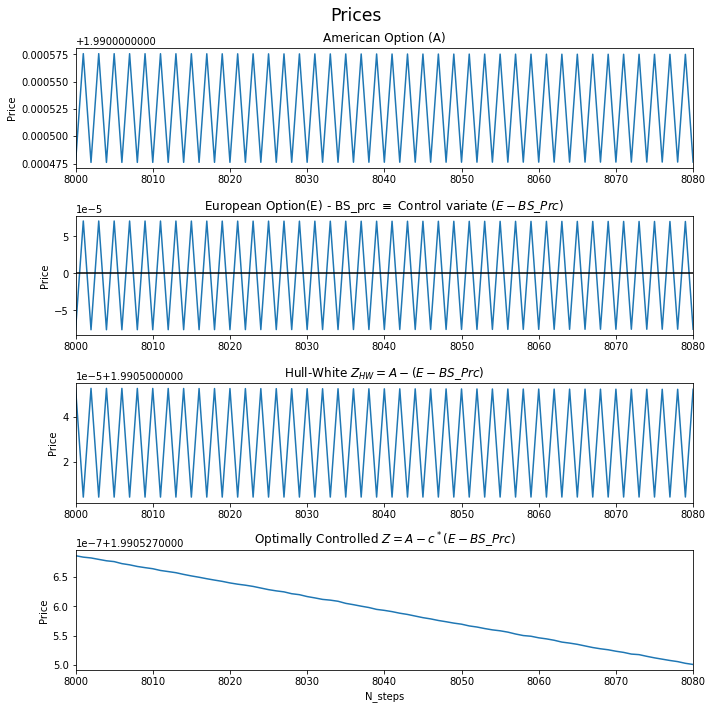

Optimal Control Variate coefficient c*: 0.6767
Variance | stddev of A:    2.486e-09 | 4.986e-05
Variance | stddev of Z_HW: 5.673e-10 | 2.382e-05
Variance | stddev of Z:    3.039e-15 | 5.513e-08
Mean A | Mean E - BS_prc:   1.990525165 | -0.000003588


array([1.99052769, 1.99052768, 1.99052768, 1.99052768, 1.99052768,
       1.99052768, 1.99052767, 1.99052767, 1.99052767, 1.99052767])

In [26]:
# Repeat for N_steps on [8000, 8080]:
N_steps, a, e = np.loadtxt("prcs_8000-8080.csv", delimiter=',', unpack=True)

# Plot A and E - BS_prc:
fig, ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(N_steps, a)
ax[0].set_title("American Option (A)")
ax[0].set_xlim(N_steps[0], N_steps[-1])
ax[0].set_ylabel('Price')

ax[1].plot(N_steps, e - BS_prc)
ax[1].set_title("European Option(E) - BS_prc $\equiv$ Control variate ($E-BS\_Prc$)")
ax[1].axhline(y=0, color="black")
ax[1].set_xlim(N_steps[0], N_steps[-1])
ax[1].set_ylabel('Price')

# Create z_HW, and Z from c:
z_HW = a - (e - BS_prc)
var_Z_HW = z_HW.var(ddof=1)
cov_A_E = np.cov(a, e)
c = cov_A_E[0,1] / cov_A_E[1,1]
var_A = cov_A_E[0,0]
z = a - c * (e - BS_prc)
var_Z = z.var(ddof=1)

ax[2].plot(N_steps, z_HW)
ax[2].set_title("Hull-White $Z_{HW}=A - (E-BS\_Prc)$")
ax[2].set_xlim(N_steps[0], N_steps[-1])
ax[2].set_ylabel('Price')

ax[3].plot(N_steps, z)
ax[3].set_title("Optimally Controlled $Z=A - c^*(E-BS\_Prc)$")
ax[3].set_xlim(N_steps[0], N_steps[-1])
ax[3].set_xlabel('N_steps')
ax[3].set_ylabel('Price')
fig.suptitle("Prices", fontsize="xx-large")

fig.tight_layout()
plt.show()

print(f"Optimal Control Variate coefficient c*: {c:.4}")
print(f"Variance | stddev of A:    {var_A:6.3e} | {math.sqrt(var_A):6.3e}")
print(f"Variance | stddev of Z_HW: {var_Z_HW:6.3e} | {math.sqrt(var_Z_HW):6.3e}")
print(f"Variance | stddev of Z:    {var_Z:6.3e} | {math.sqrt(var_Z):6.3e}")
print(f"Mean A | Mean E - BS_prc:   {a.mean():10.9f} | {(e-BS_prc).mean():10.9f}")


Notice how much less variance there is in $Z$ compared with A or $Z_{HW}$. The vertical scale is two orders of magnitude smaller. But how much lower do Z and A go as N_step $\rightarrow \infty$ ?

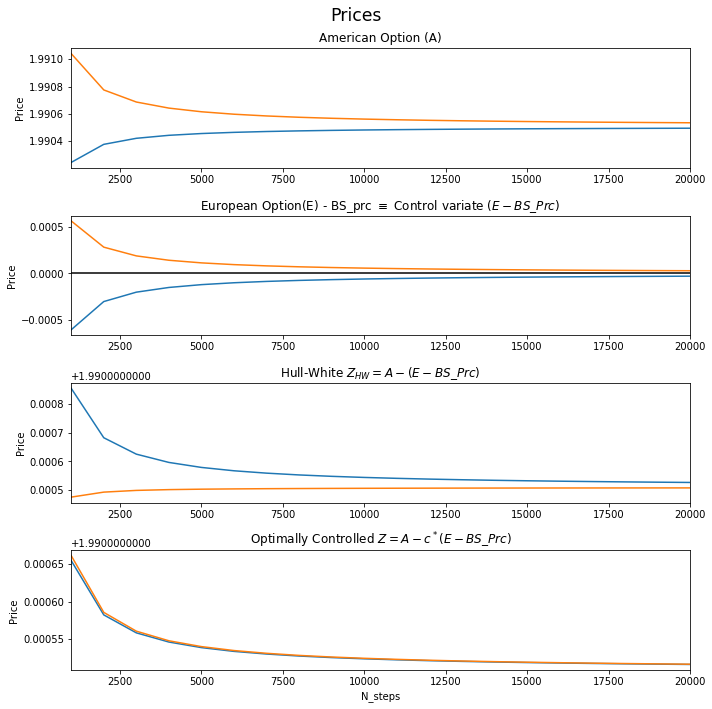

Optimal Control Variate coefficient c*: 0.671
Variance | stddev of A:    1.386e-08 | 1.177e-04
Variance | stddev of Z_HW: 4.159e-09 | 6.449e-05
Variance | stddev of Z:    1.087e-09 | 3.297e-05


array([1.99065468, 1.9906612 , 1.99058217, 1.99058549, 1.99055819,
       1.99056042, 1.99054593, 1.99054761, 1.99053849, 1.99053984])

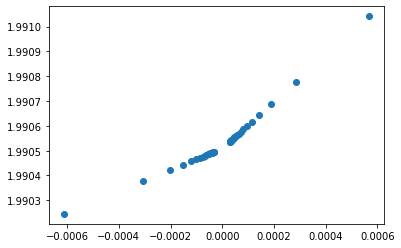

In [25]:
# Repeat for N_steps on [1000, 20001]:
N_steps, a, e = np.loadtxt("prcs_1000-20000.csv", delimiter=',', unpack=True)

# Plot A and E - BS_prc:
fig, ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(N_steps[::2], a[::2])
ax[0].plot(N_steps[1::2], a[1::2])
ax[0].set_title("American Option (A)")
ax[0].set_xlim(N_steps[0], N_steps[-1])
ax[0].set_ylabel('Price')

ax[1].plot(N_steps[::2], e[::2] - BS_prc)
ax[1].plot(N_steps[1::2], e[1::2] - BS_prc)
ax[1].set_title("European Option(E) - BS_prc $\equiv$ Control variate ($E-BS\_Prc$)")
ax[1].axhline(y=0, color="black")
ax[1].set_xlim(N_steps[0], N_steps[-1])
ax[1].set_ylabel('Price')

# Create z_HW, and Z from c:
z_HW = a - (e - BS_prc)
var_Z_HW = z_HW.var(ddof=1)
cov_A_E = np.cov(a, e)
c = cov_A_E[0,1] / cov_A_E[1,1]
var_A = cov_A_E[0,0]
z = a - c * (e - BS_prc)
var_Z = z.var(ddof=1)

ax[2].plot(N_steps[::2], z_HW[::2])
ax[2].plot(N_steps[1::2], z_HW[1::2])
ax[2].set_title("Hull-White $Z_{HW}=A - (E-BS\_Prc)$")
ax[2].set_xlim(N_steps[0], N_steps[-1])
ax[2].set_ylabel('Price')

ax[3].plot(N_steps[::2], z[::2])
ax[3].plot(N_steps[1::2], z[1::2])
ax[3].set_title("Optimally Controlled $Z=A - c^*(E-BS\_Prc)$")
ax[3].set_xlim(N_steps[0], N_steps[-1])
ax[3].set_xlabel('N_steps')
ax[3].set_ylabel('Price')
fig.suptitle("Prices", fontsize="xx-large")

fig.tight_layout()
plt.show()

print(f"Optimal Control Variate coefficient c*: {c:.4}")
print(f"Variance | stddev of A:    {var_A:6.3e} | {math.sqrt(var_A):6.3e}")
print(f"Variance | stddev of Z_HW: {var_Z_HW:6.3e} | {math.sqrt(var_Z_HW):6.3e}")
print(f"Variance | stddev of Z:    {var_Z:6.3e} | {math.sqrt(var_Z):6.3e}")
# Scatter plot of A vs E - BS_prc:
fig, ax = plt.subplots()
ax.scatter(e - BS_prc, a)


Above are plotted the upper and lower envelopes of the alternating series that are A, E - BS_prc, $Z_{HW}$ and $Z$. For any fixed interval of `N_steps`, the variance of A, E and $Z_{HW}$ is dominated by the alternating, while that of $Z$ by the seriel drift. The problem with using $Z$ to estimate the true A is that it continues drifting lower. But the lower envelops of the other series are increasing. 

### An Implementation
#### Training Set `N_steps` on [20, 100]
Borrowing from ML terminology we will calculate the optimal $c^*$ on the *training* set of binomial trees having `N_steps` time steps on [20, 100], and then we will use this $c^*_{train}$ to estimate the price of the American option on a large tree having `N_steps` near 1000-10000. We first confirm that this choice of $c^*_{train}$ leads to reduced variance within the training set in line with the above formula.

We calculate the sample variances for each of: the American option prices, the American option prices using control variate with $c=1$, the American option prices using the optimal control variate ($c^*_{train}$). We check the $c=1$ case just because Hull-White, and M. Joshi each use $c=1$ and to confirm this choice is not optimal. We find the ratio $${Var[Z]\over Var[X]}= {1.46672e-06\over 8.17512e-05} = 0.01794$$ agrees with the expected $(1 - Corr^2[X, Y]) = 1 - 0.990989^2$ for this training set (`N_steps` on [20, 100]).



#### Test Set`N_steps` on [4000, 4080]
One could repeat the same calculations for a *test* set of binomial trees having `N_steps` on [4000, 4080]. This gives analogous results with all variances reduced, as these larger trees produce more accurate results (averaging $\sim 4000$ numbers together for each of those 81 tree's price). And, since the correlation is closer to 1, the reduction in variance by using the control variate is higher ($= 1- Corr^2[X,Y]$, using $c^*_{test}$). 

Following the above authors, we use $c^*_{train}$ to generate $Z$. The justification is that we can generate many smaller trees with which to estimate a $c^*$ to then use to reduce the variance of results on the computationally more expensive larger trees.

The following results confirm that $c^*_{train}$ does a good job reducing the variance on the test set:
$${Var[Z]\over Var[X]}= {1.105301891e-12\over 9.845159608e-09} = 0.00011227$$
Of course $c^*_{test}$ does a better job (and that should therefore be used if you are generating enough large trees to give a good estimate of $c^*_{test}$. )
$$(1-Corr^2[X,Y], \text{using } c^*_{test}) = 1-0.9999976253^2 = 0.00000475$$

Note: The variance  is small enough to see a trend: the estimated American option prices decrease from 1.99065 to 1.99055 as `N_steps` increases from 1000 to 4000. Increasing `N_steps` by 1 near `N_steps`=4000 shows the familiar up/down price dependence. The up/down price envelope of the covariate corrected prices is decreasing, the (larger) up/down price envelope of the raw prices is increasing. Exrapolating these, or fitting some curve to them, may give a better option price estimate.

The upshot of all this, barring completion of the mentioned study to fit extrapolating curves, is that a European option as control variate with $c^* = c^*_{small}$ gives low variance price estimates for the corresponding American. But one should sample prices from a few binomial trees having larger `N_steps` to see if there is a trend detectable given this low noise observational tool.

In [ ]:
// On test set of binomial trees same number, N_points, of points as training sample
// but all trees having N_steps >> end_N.
// Test grid: [4000 : 4000 + N_points]
using std::cout;
using std::endl;

int test_start_N = 4000;
int test_end_N = 4000 + N_points - 1;
cout << "\nTest set (binomial trees having N_steps on [" << test_start_N << " : "
<< test_end_N << "]) Results:" << endl;

for (int N_steps = test_start_N; N_steps < test_end_N + 1; ++N_steps) {
    amer_prcs[N_steps - test_start_N] = amer_put.btree_prc(N_steps, r, get_greeks);
    euro_prcs[N_steps - test_start_N] = euro_put.btree_prc(N_steps, r, get_greeks);
}

// Calculate their sample means, vars and covariance:
amer_mean = amer_prcs.sum() / N_points;
euro_mean = euro_prcs.sum() / N_points;

var_amer = ((amer_prcs - amer_mean) * (amer_prcs - amer_mean)).sum() / (N_points - 1);
var_euro = ((euro_prcs - euro_mean) * (euro_prcs - euro_mean)).sum() / (N_points - 1);
cov_a_e = ((amer_prcs - amer_mean) * (euro_prcs - euro_mean)).sum() / (N_points - 1);
// Get the theoretical optimum mix of the Euro option control variate (for this parameter set):
double c_testset = cov_a_e / var_euro;
cout << "Optimal c (in test set): " << c_testset << endl;
cout << "Test set Corr(Amer, Euro): " << cov_a_e / (sqrt(var_amer) * sqrt(var_euro)) << endl;

// Get the variance of Amer option prices via the optimal, and the Hull, White (c==1) control
// variate admixture:
amer_prcs_HW = amer_prcs - (euro_prcs - BS_prc);
amer_prcs_opt = amer_prcs - c * (euro_prcs - BS_prc); // Use c from training set!
amer_mean_HW = amer_prcs_HW.sum() / N_points;
amer_mean_opt = amer_prcs_opt.sum() / N_points;
var_amer_HW = ((amer_prcs_HW - amer_mean_HW) * (amer_prcs_HW - amer_mean_HW)).sum() / (N_points - 1);
var_amer_opt = ((amer_prcs_opt - amer_mean_opt) * (amer_prcs_opt - amer_mean_opt)).sum() / (N_points - 1);



cout << "Var and stddev of Z = A -c(E - BS_prc):" << endl;
cout << "         c                  Var | stddev" << endl;
cout << "None, c=0            " << var_amer << '|' << sqrt(var_amer) << endl;
cout << "Hull-White, c=1      " << var_amer_HW << '|' << sqrt(var_amer_HW) << endl;
cout << "Optimal c_train      " << var_amer_opt << '|' << sqrt(var_amer_opt) << endl;
cout << "Mean of raw American prices: " << std::setprecision(10) << amer_mean << endl;
cout << "Mean of Hull-White prices:   " << std::setprecision(10) << amer_mean_HW << endl;
cout << "Mean of opt c_train prices:  " << std::setprecision(10) << amer_mean_opt << endl;
cout << "Mean of raw European prices: " << std::setprecision(10) << euro_mean << endl;
